# Práctica Calificada 2
---
**Predicción de tarifas de taxis**<br>
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de
predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score, precision_recall_curve
from inspect import signature
from math import sqrt, sin, cos, asin, pi
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
%matplotlib inline

* **ID**: cadena que identifica de manera única a cada registro
* **pickup_datetime**: timestamp indicando cuando el viaje a empezado
* **pickup_longitude**: número real indicando la ubicación en **longitud** en donde el viaje
empezó
* **pickup_latitude**: número real indicando la ubicación en **latitud** en donde el viaje
empezó
* **dropoff_longitude**: número real indicando la ubicación en longitud en donde el viaje
terminó
* **dropoff_latitude**: número real indicando la ubicación en latitud en donde el viaje
terminó
* **passenger_count**: número entero indicando el número de pasajeros en el servicio de
taxi
* **fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir**

<h4>Poblacion</h4>

In [3]:
%%time
df = pd.read_csv("train.csv") # cambiar esto por train.csv para cargar los 55M .

Wall time: 12min 4s


In [ ]:
df.describe()

<h4>Muestra</h4>

In [4]:
%%time
# 1000000 sample
df_s = df.sample(1000000, random_state = 7)
df_s.to_csv("1M_train")

Wall time: 14min 21s


In [5]:
df_s.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
17358777,2009-12-16 19:56:08.0000002,6.1,2009-12-16 19:56:08 UTC,-73.960564,40.769658,-73.965808,40.755327,1
53320139,2012-05-03 09:31:00.000000164,6.1,2012-05-03 09:31:00 UTC,-74.001433,40.735952,-73.991040,40.744595,1
42864741,2013-07-25 19:08:33.0000003,11.5,2013-07-25 19:08:33 UTC,-73.972948,40.743595,-73.994399,40.740419,1
26375625,2011-12-02 16:30:00.00000089,3.3,2011-12-02 16:30:00 UTC,-73.966550,40.767238,-73.966448,40.767265,1
41418930,2014-01-08 03:43:57.0000001,19.5,2014-01-08 03:43:57 UTC,-73.975016,40.749072,-73.891663,40.769113,1


In [6]:
df_s.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999993.000000,999993.000000,1000000.000000
mean,11.327786,-72.520348,39.929225,-72.527959,39.922299,1.683515
std,9.815542,12.191802,9.700116,11.929513,8.256824,1.322798
min,-52.000000,-2983.442992,-3124.489865,-2983.442992,-3461.540872,0.000000
25%,6.000000,-73.992070,40.735012,-73.991395,40.734037,1.000000
50%,8.500000,-73.981815,40.752681,-73.980142,40.753195,1.000000
75%,12.500000,-73.967083,40.767152,-73.963689,40.768143,2.000000
max,850.000000,3438.030813,3376.601917,2494.336265,2402.117805,208.000000


In [7]:
df_s.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

<h4>Data Cleaning y Transformación de la Data</h4>

In [8]:
# Se trabajará con la siguiente data:
# Region: New York
# 

data = df_s[(-74.252444 <= df_s["pickup_longitude"]) & (df_s["pickup_longitude"] <= -73.629885) &
            (40.497175 <= df_s["pickup_latitude"]) & (df_s["pickup_latitude"] <= 40.825076) & 
            (-74.252444 <= df_s["dropoff_longitude"]) & (df_s["dropoff_longitude"] <= -73.629885) &
            (40.497175 <= df_s["dropoff_latitude"]) & (df_s["dropoff_latitude"] <= 40.825076)&
            (2.0 <= df_s["fare_amount"]) & (df_s["fare_amount"] <= 200) & 
            (0.0 < df_s["passenger_count"]) & (df_s["passenger_count"] <= 8) &
            (df_s["pickup_longitude"] != df_s["dropoff_longitude"])]

data ['pickup_datetime'] = pd.to_datetime(data.pickup_datetime) # convertimos a tipo de dato de datetime
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour

data.drop(columns='key', inplace=True)
data.drop(columns='pickup_datetime', inplace=True)

data.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
17358777,6.1,-73.960564,40.769658,-73.965808,40.755327,1,2009,12,16,19
53320139,6.1,-74.001433,40.735952,-73.991040,40.744595,1,2012,5,3,9
42864741,11.5,-73.972948,40.743595,-73.994399,40.740419,1,2013,7,25,19
26375625,3.3,-73.966550,40.767238,-73.966448,40.767265,1,2011,12,2,16
41418930,19.5,-73.975016,40.749072,-73.891663,40.769113,1,2014,1,8,3


In [9]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
count,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000
mean,11.126503,-73.975861,40.750600,-73.975297,40.750089,1.689677,2011.743266,6.265574,15.699261,13.523608
std,9.208447,0.033844,0.026220,0.033213,0.028829,1.304833,1.866433,3.435871,8.674179,6.494233
min,2.500000,-74.250388,40.506347,-74.251572,40.504980,1.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992341,40.736520,-73.991705,40.735232,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.982180,40.753192,-73.980877,40.753472,1.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.968697,40.767227,-73.966455,40.767776,2.000000,2013.000000,9.000000,23.000000,19.000000
max,200.000000,-73.631367,40.825055,-73.632115,40.825076,6.000000,2015.000000,12.000000,31.000000,23.000000


In [10]:
data.shape

(951943, 10)

In [11]:
data.sort_values(by='pickup_longitude', ascending=False).tail(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
42187142,35.7,-74.236065,40.774652,-74.243035,40.775842,4,2011,1,11,19
37365669,3.3,-74.237608,40.775825,-74.239608,40.775108,5,2010,11,3,19
29068103,7.3,-74.238963,40.775562,-74.239852,40.775577,2,2011,5,24,11
49644569,16.5,-74.239403,40.762333,-74.245288,40.726913,1,2009,8,26,19
11414830,36.9,-74.250388,40.776073,-74.245213,40.792067,1,2011,11,18,15


<AxesSubplot:>

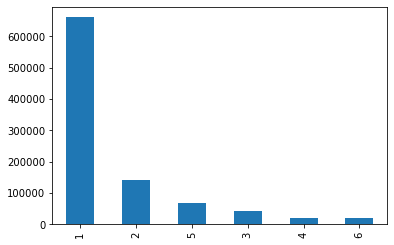

In [12]:
data["passenger_count"].value_counts().plot(kind="bar")

<AxesSubplot:xlabel='fare_amount', ylabel='Frequency'>

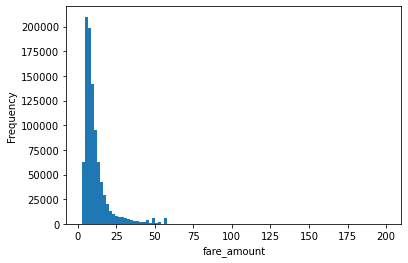

In [13]:
plt.xlabel("fare_amount")
data["fare_amount"].plot.hist(alpha=1, stacked=True, bins=100)

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

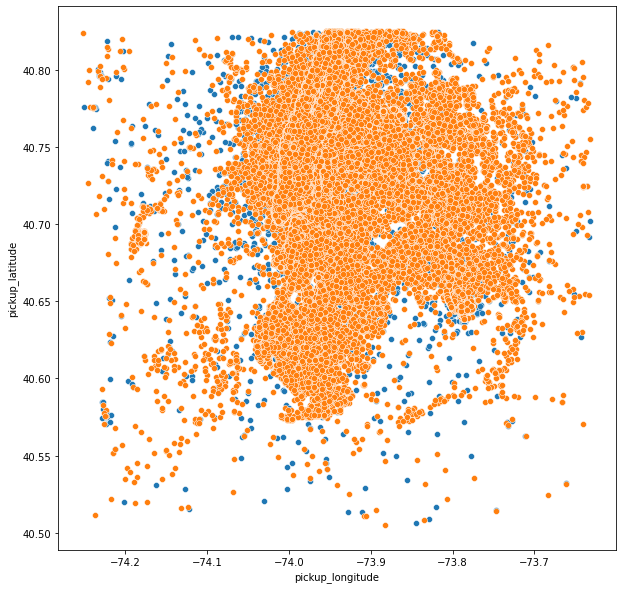

In [14]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data["pickup_longitude"], data["pickup_latitude"])
sns.scatterplot(data["dropoff_longitude"], data["dropoff_latitude"])

In [17]:
data.isna().sum(), data.isnull().sum()

(fare_amount          0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count      0
 year                 0
 month                0
 day                  0
 hour                 0
 dtype: int64,
 fare_amount          0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count      0
 year                 0
 month                0
 day                  0
 hour                 0
 dtype: int64)

<h4>Ingeniería de Características</h4>

In [18]:
#Distancia entre dos puntos (Métrica de Haversine)
# two ways 
# 1  : Using the package

#from haversine import haversine
#origin = (39.50, 98.35)
#paris = (48.8567, 2.3508)
#haversine(origin, paris, miles=False) # return the distance in km

# 2 def a function

def radian(sexag):
    return sexag*(pi/180.0)

def Haversine(lat1,lon1,lat2,lon2):
    if (lat1 == lat2 and lon1 == lon2):
        return 0.0001 # por mientras
    diffLat = radian(lat2-lat1)
    diffLon = radian(lon2-lon1)
    h = sin(diffLat/2) ** 2 + cos(radian(lat1))*cos(radian(lat2))*(sin(diffLon/2)**2)
    dKm = 2.0 * 6371.345 * asin(sqrt(h))
    return dKm 

#print(Haversine(39.50, 98.35, 48.8567, 2.3508))

data['distance'] = data.apply(lambda row: Haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
count,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000,951943.000000
mean,11.126503,-73.975861,40.750600,-73.975297,40.750089,1.689677,2011.743266,6.265574,15.699261,13.523608,3.251986
std,9.208447,0.033844,0.026220,0.033213,0.028829,1.304833,1.866433,3.435871,8.674179,6.494233,3.432523
min,2.500000,-74.250388,40.506347,-74.251572,40.504980,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000084
25%,6.000000,-73.992341,40.736520,-73.991705,40.735232,1.000000,2010.000000,3.000000,8.000000,9.000000,1.270145
50%,8.500000,-73.982180,40.753192,-73.980877,40.753472,1.000000,2012.000000,6.000000,16.000000,14.000000,2.152730
75%,12.500000,-73.968697,40.767227,-73.966455,40.767776,2.000000,2013.000000,9.000000,23.000000,19.000000,3.846501
max,200.000000,-73.631367,40.825055,-73.632115,40.825076,6.000000,2015.000000,12.000000,31.000000,23.000000,37.437210


<h4> Definición del modelo a entrenar </h4>

In [19]:
%%time
predictors = ['distance']
salida = 'fare_amount'

X = data[predictors]
y = data[salida]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Imprime el b y lso coeficientes
print(f'Intercepto: {modelo.intercept_:.3f}')
print(f'Coeficientes: {modelo.coef_[0]:.3f}')

Intercepto: 3.428
Coeficientes: 2.366
Wall time: 319 ms


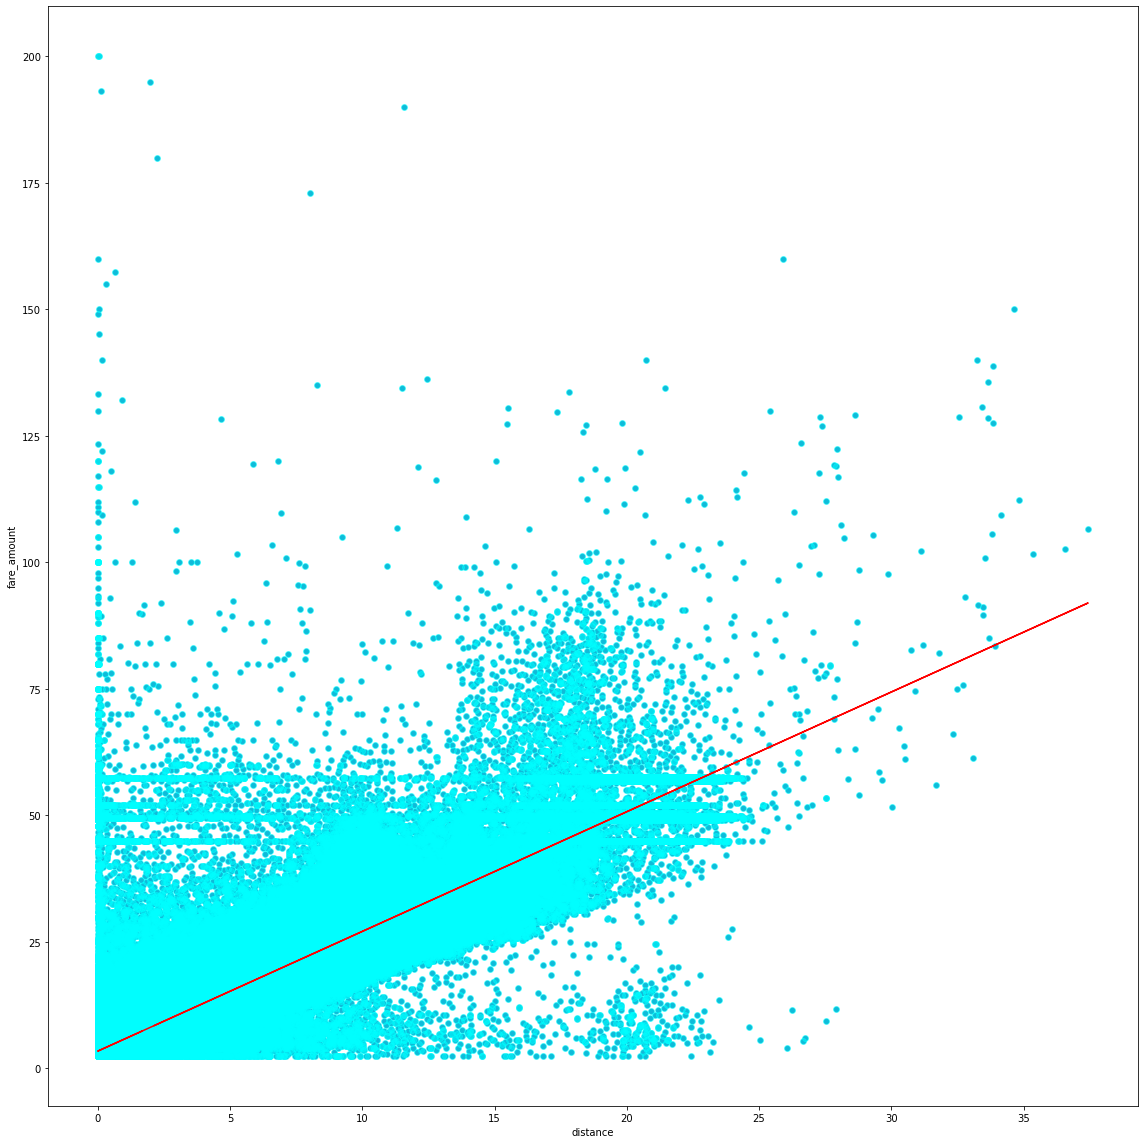

In [20]:
# comparo el valor predicho de todos los puntos dados con el calculado
fitted = modelo.predict(data[predictors])
residuals = data[salida] - fitted

ax = data.plot.scatter(x="distance", y="fare_amount", figsize=(16, 16))
ax.scatter(data.distance, data.fare_amount, alpha=0.5, c='aqua')
ax.plot(data.distance, fitted, c="red")
"""
for x, y_actual, y_fitted in zip(data.distance, data.fare_amount, fitted):
    ax.plot((x, x), (y_actual, y_fitted), "--", color="C1")
"""    
plt.tight_layout()
plt.show()

In [21]:
modelo.score(X_test, y_test)

0.7813622750306737

## Metrics

In [ ]:
# datos de entrenamiento y el ajustado
print("MSE", mean_squared_error(data[salida], fitted))

# r2_score
print("R2", r2_score(data[salida], fitted))